## Install (Colab only)
Skip this step when running locally.

In [1]:
# !pip install ...

# Import libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import pickle
import time

# Keras
from keras import Sequential, Input
from keras.callbacks import Callback, EarlyStopping
from keras.saving import load_model, register_keras_serializable
from keras.models import Model
from keras.layers import GRU, Embedding, Dense, TimeDistributed, Bidirectional, LSTM, Dropout
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# filter some user warnings from torch broadcast
import warnings
warnings.filterwarnings("ignore")

In [3]:
# TF / Keras random number generator
tf.random.set_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Pre: Compare 4 different models to determine best

Goal here is to determine which of the 4 models is the best based on the metrics used.

The 4 initial runs had arbitrary hyperparameters, with
1. 1 embedding layer
2. 2 hidden layers with Dropout (applied at the output), and
3. TimeDistributed Densely connected output layer

And was only run on 51% of one of the simplified dataset.

In [4]:
# Loading all files
LABELS = ['GRU', 'LSTM', 'BI-GRU', 'BI_LSTM']

data = {
    prefix: {
        'history': None,
        'history_times': None
    } for prefix in LABELS
}

for prefix in LABELS:
    with open(f'{prefix}.history.pkl', 'rb') as f:
        data[prefix]['history'] = pickle.load(f)
    with open(f'{prefix}.history_times.pkl', 'rb') as f:
        data[prefix]['history_times'] = pickle.load(f)

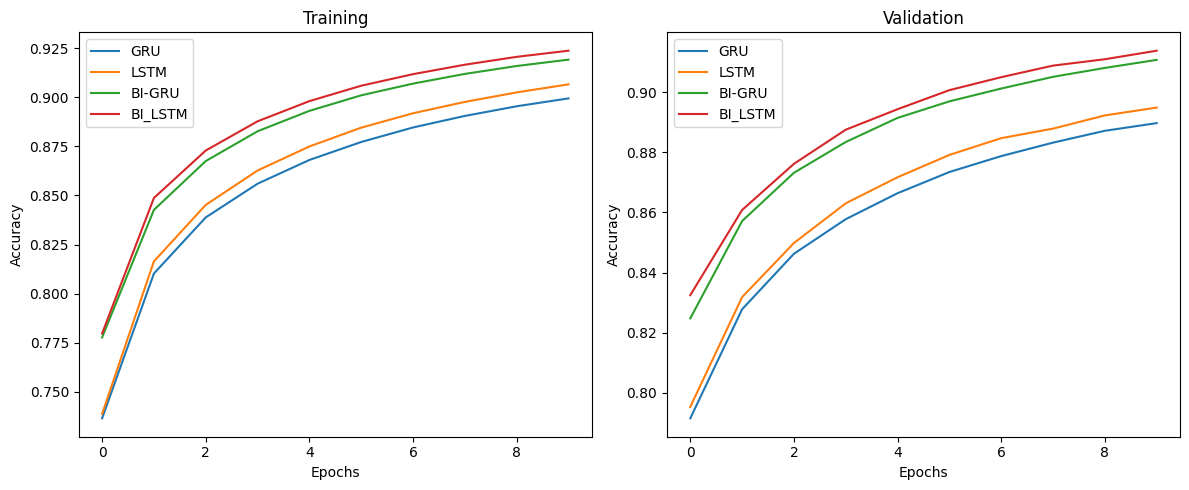

In [5]:
# Plotting histories
KEYS = ['q3_acc', 'val_q3_acc']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, key in enumerate(KEYS):

    axs[i].plot(data[LABELS[0]]['history'][key], label=LABELS[0])
    axs[i].plot(data[LABELS[1]]['history'][key], label=LABELS[1])
    axs[i].plot(data[LABELS[2]]['history'][key], label=LABELS[2])
    axs[i].plot(data[LABELS[3]]['history'][key], label=LABELS[3])

    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Accuracy')
    axs[i].legend()

axs[0].set_title('Training')
axs[1].set_title('Validation')

plt.tight_layout()
plt.show()

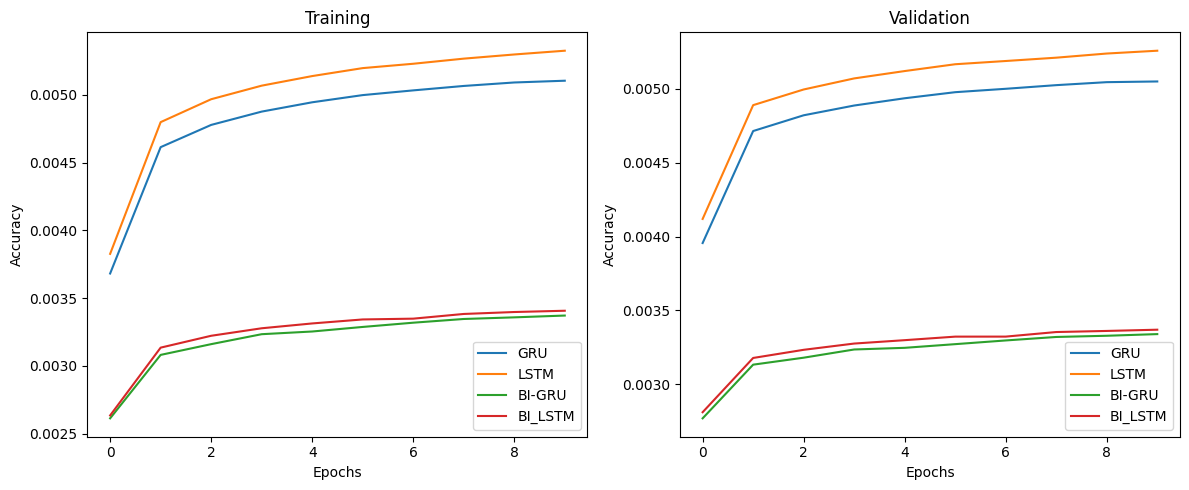

In [6]:
# Plotting histories, normalised against runtime
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, key in enumerate(KEYS):
    for label in LABELS:
        # Convert lists to numpy arrays for element-wise division
        history_values = np.array(data[label]['history'][key])
        history_times = np.array(data[label]['history_times'])
        normalized_values = history_values / history_times

        axs[i].plot(normalized_values, label=label)

    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Accuracy')
    axs[i].legend()

axs[0].set_title('Training')
axs[1].set_title('Validation')

plt.tight_layout()
plt.show()


Conclusion:
- LSTM generally has a higher q3_accuracy than GRU
- Bi-directional has a higher q3_accuracy than without, but much slower

Best model for q3_accuracy is Bi-direction LSTM,

however it is noted that for prototyping GRU may be suitable as the accuracy is very close for a much shorter training interval.

# Improving the model further

Now that the best model is determined to be *bi-directional LSTM*, we will improve it further and use it on a larger segment of the dataset.

In [7]:
# Loading the model.keras to get the current model

@register_keras_serializable()
def q3_acc(y_true, y_pred):
    # Get the true and predicted class indices
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)

    # Create a mask to exclude any unwanted classes (e.g., padding with index 0)
    mask = y > 0

    # Calculate accuracy on masked values
    correct_predictions = tf.boolean_mask(y, mask) == tf.boolean_mask(y_, mask)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))

    return accuracy

old_model = load_model('BI_LSTM.model.keras', {'q3_acc': q3_acc})
old_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 300, 128)            │       1,077,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 300, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 300, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 300, 4)              │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,208,590 (19.87 MB)

 Trainable params: 1,736,196 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,472,394 (13.25 MB)